In [12]:
import numpy as np
from sus.protocol_designer import System, Protocol, Potential, Compound_Protocol
from sus.protocol_designer.protocol import sequential_protocol
from IPython import display
from IPython.display import HTML
from quick_sim import setup_sim
from edward_tools.coupled_fq_potential import coupled_flux_qubit_pot, coupled_flux_qubit_force, coupled_fq_pot
import edward_tools.fq_runner as fq_runner
from edward_tools.visualization import animate_sim_flux_qubit
from edward_tools.initial_state_sampling import self_defined_initial_state
from edward_tools.databaseInterface import saveToDataBase

import kyle_tools as kt
import matplotlib.pyplot as plt
from quick_sim import setup_sim

import importlib, os, hashlib, json, datetime
from edward_tools import coupled_fq_protocol_library, cfq_runner
from PARAMETER_INPUT import *
from PARAMETER_INPUT import _lambda, _theta, _eta
from ControlParameter import *

import edward_tools.cfq_batch_sweep as cfq_batch_sweep
%load_ext jupyternotify

coupled_fq_protocol_library = importlib.reload(coupled_fq_protocol_library)
create_system = coupled_fq_protocol_library.create_system
get_potential_shot_at_different_t = coupled_fq_protocol_library.get_potential_shot_at_different_t
get_potential_shot_at_different_t_1D = coupled_fq_protocol_library.get_potential_shot_at_different_t_1D
create_simple_protocol_parameter_dict = coupled_fq_protocol_library.create_simple_protocol_parameter_dict
create_system_from_storage_and_computation_protocol = coupled_fq_protocol_library.create_system_from_storage_and_computation_protocol
coupled_fq_runner = importlib.reload(cfq_runner)
coupled_fq_protocol_library = importlib.reload(coupled_fq_protocol_library)
create_system = coupled_fq_protocol_library.create_system


The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [2]:
def analysis_protocol_function(var_name, var_value, simResult):
    average_work = simResult["work_statistic"][:,0][-1]
    jarzyn_term = np.mean(np.exp(-simResult["work_distribution"]))
    fidelity_data = simResult["fidelity"]

    saveData = {
        var_name:       var_value,
        "fidelity":     fidelity_data,
        "average_work": average_work,
        "jarzyn_term":  jarzyn_term
    }

    json_path = f"coupled_flux_qubit_protocol/{var_name}_analysis.json"
    
    print(os.path.isfile(json_path))
    
    
    if not os.path.isfile(json_path):
        with open(json_path, "w") as fw:
            jsonData = []
            json.dump(jsonData, fw)
        
    with open(json_path, "r") as fr:
        jsonData = json.load(fr)
        jsonData.append(saveData)
        print(jsonData)
        with open(json_path, "w+") as fw:
            json.dump(jsonData, fw)

In [25]:
"""
# step 0: modify parameters
- All the parameters are stored in a separate file PARAMETER_INPUT
- You can override some of the parameters here.
"""
params['N'] = 10_000
params['dt'] = 1/100
print(N, params['dt'])
print(phi_1_dcx_on, phi_2_dcx_on, M_12_on)

10000 0.01
2.8 2.8 -0.5


In [4]:
"""
# step 1: Define potential
"""
coupled_fq_default_param = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x_c0]
[phi_1_bound, phi_2_bound, phi_1dc_bound, phi_2dc_bound] = np.array([4, 4, 4, 4])/time_scale_factor

coupled_fq_domain = [[-phi_1_bound, -phi_2_bound, -phi_1dc_bound, -phi_2dc_bound], \
                     [phi_1_bound, phi_2_bound, phi_1dc_bound, phi_2dc_bound]]

coupled_fq_pot = Potential(coupled_flux_qubit_pot, coupled_flux_qubit_force, 14, 4,\
                           default_params = coupled_fq_default_param,  relevant_domain = coupled_fq_domain)

In [16]:
"""
# step 2: Define initial condition and protocol
"""
manual_domain=[np.array([-5, -5]), np.array([5, 5])]
phi_1_dcx, phi_2_dcx = 0, 0
phi_1_dc, phi_2_dc = phi_1_dcx, phi_2_dcx

# time length
time_length_1 = 80
time_length_2 = 40
time_length_3 = 40
time_length_4 = 40
time_length_5 = 60
time_length_6 = 60

phi_1_dcx_on = 2.8
phi_2_dcx_on = 2.8
M_12_on = -0.5

In [17]:
initial_parameter_dict = {
        "U0_1": U0_1,     "U0_2": U0_2,     "gamma_1": gamma,  "gamma_2": gamma,
        "beta_1": beta_1,   "beta_2": beta_2,   "d_beta_1": d_beta_1 ,   "d_beta_2": d_beta_2,
        "phi_1_x": 0,  "phi_2_x": 0,  "phi_1_dcx": phi_1_dcx_off,  "phi_2_dcx": phi_2_dcx_off,
        "M_12": M_12_off, 'x_c': x_c
}


protocol_list_options = [
    {"placeholder": ""},
    # forward
    {"duration":time_length_1, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_on,  "M_12": M_12_off,  "name":"(1) mix in y direction"},
    {"duration":time_length_2, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_on,  "M_12": M_12_on,   "name":"(2) conditional tilt"},
    {"duration":time_length_3, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_on,   "name":"(3) raise the barrier"},
    {"duration":time_length_4, "phi_1_dcx": phi_1_dcx_off,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(4) 4 well potential 1st time"}, 
    {"duration":time_length_5, "phi_1_dcx": phi_1_dcx_on,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(5) mix in x direction"}, 
    {"duration":time_length_6, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(6) 4 well potential"}, 
    
    # reverse
    {"duration":time_length_6, "phi_1_dcx": phi_1_dcx_on,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(-6) 4 well potential 2nd time"}, 
    {"duration":time_length_5, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(-5) anti-mix in x direction"}, 
    {"duration":time_length_4, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_on,   "name":"(-4) anti-raise the barrier 1st time"},
    {"duration":time_length_3, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_on,  "M_12":  M_12_on,  "name":"(-3) anti-raise the barrier"},
    {"duration":time_length_2, "phi_1_dcx":phi_1_dcx_off,  "phi_2_dcx": phi_2_dcx_on,  "M_12": M_12_off,  "name":"(-2) anit-conditional tilt"},
    {"duration":time_length_1, "phi_1_dcx":phi_1_dcx_off,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(-1) anti- mix in y direction"}
]

In [26]:
zeroDissipation = False
params['sim_params'] = [_lambda , _theta, _eta]
# params['sim_params'] = [_lambda * 10  , _theta, _eta * 10]
if zeroDissipation:
    params['sim_params'] = [_lambda * 0, _theta, _eta * 0]



"""
1 <-> -1     (0, 0, 0), (0, 3, 0), (0, 0, 0)
2 <-> -2     (0, 3, 0), (0, 3, -0.05), (0, 3, 0)
3 <-> -3     (0, 3, -0.05), (0, 0, -0.05), (0, 3, -0.05)
4 <-> -4     (0, 0, -0.05), (0, 0, 0), (0, 0, -0.05)
5 <-> -5     (0, 0, 0), (3, 0, 0), (0, 0, 0)
6 <-> -6     (3, 0, 0), (0, 0, 0), (3, 0, 0)
(1) mix in y direction, (2) conditional tilt, (3) raise the barrier
(4) 4 well potential 1st time,  (5) mix in x direction, (6) 4 well potential
"""
TR_initial_condition = [
    (phi_1_dcx_off, phi_2_dcx_off, M_12_off), 
    (phi_1_dcx_off, phi_2_dcx_on,  M_12_off), 
    (phi_1_dcx_off, phi_2_dcx_on,  M_12_on), 
    (phi_1_dcx_off, phi_2_dcx_off, M_12_on), 
    (phi_1_dcx_off, phi_2_dcx_off, M_12_off), 
    (phi_1_dcx_on,  phi_2_dcx_off, M_12_off)]

protocol_index = 4

# initial_parameter_dict["phi_1_dcx"], initial_parameter_dict["phi_2_dcx"], initial_parameter_dict["M_12"] = TR_initial_condition[protocol_index]



# protocol_list = [
#     # forward
#     protocol_list_options[protocol_index-1],
    
#     # reverse
#     protocol_list_options[-protocol_index]
# ]

# full process
initial_parameter_dict["phi_1_dcx"], initial_parameter_dict["phi_2_dcx"], initial_parameter_dict["M_12"] = TR_initial_condition[0]
rest = lambda t: {"duration": t, "name":"rest"}

protocol_list = [
    # forward
    # protocol_list_options[protocol_index + 1],
    protocol_list_options[1],
    rest(60), 
    protocol_list_options[2],
    rest(40), 
    protocol_list_options[3],
    rest(40), 
    protocol_list_options[4],
    # protocol_list_options[5],
    # rest,
    # protocol_list_options[6],

    
    
    # reverse
    # protocol_list_options[-5],
    # protocol_list_options[-4],
    # protocol_list_options[-3],
    # protocol_list_options[-2],
    # protocol_list_options[-1]
    # protocol_list_options[-(protocol_index + 1)]
]


print("sim_params", params['sim_params'])
print(f"initial parameters: phi_1_dcx: {initial_parameter_dict['phi_1_dcx']}, phi_2_dcx: {initial_parameter_dict['phi_2_dcx']}, M_12: {initial_parameter_dict['M_12']}")
for x in protocol_list:
    print(x)

# print(protocol_list[0]["phi_1_dcx"], protocol_list[0]["phi_2_dcx"], protocol_list[0]["M_12"], )
# print(protocol_list[1]["phi_1_dcx"], protocol_list[1]["phi_2_dcx"], protocol_list[1]["M_12"], )

sim_params [array([0.00269542, 0.00269542, 0.00269542, 0.00269542]), array([1., 4., 1., 4.]), array([0.01310394, 0.02620788, 0.01310394, 0.02620788])]
initial parameters: phi_1_dcx: 0, phi_2_dcx: 0, M_12: 0
{'duration': 80, 'phi_1_dcx': 0, 'phi_2_dcx': 2.8, 'M_12': 0, 'name': '(1) mix in y direction'}
{'duration': 60, 'name': 'rest'}
{'duration': 40, 'phi_1_dcx': 0, 'phi_2_dcx': 2.8, 'M_12': -0.5, 'name': '(2) conditional tilt'}
{'duration': 40, 'name': 'rest'}
{'duration': 40, 'phi_1_dcx': 0, 'phi_2_dcx': 0, 'M_12': -0.5, 'name': '(3) raise the barrier'}
{'duration': 40, 'name': 'rest'}
{'duration': 40, 'phi_1_dcx': 0, 'phi_2_dcx': 0, 'M_12': 0, 'name': '(4) 4 well potential 1st time'}


In [27]:

"""
# step 3: create the relevant storage protocol and computation protocol
"""
computation_protocol_parameter_dict = coupled_fq_protocol_library.customizedProtocol(initial_parameter_dict, \
                                                                    protocol_list)
storage_protocol, comp_protocol = create_system(computation_protocol_parameter_dict)

In [28]:
"""
# step 4: create the coupled_fq_runner
"""


cfqr = cfq_runner.coupledFluxQubitRunner(potential = coupled_fq_pot, params = params, \
                                                storage_protocol= storage_protocol, \
                                                computation_protocol= comp_protocol)
cfqr.initialize_sim()
cfqr.set_sim_attributes(extra_constraint = None)
init_state_saved = cfqr.init_state
manual_domain=[np.array([-5, -5])/time_scale_factor, np.array([5, 5])/time_scale_factor]


generating new initial_state
using a lower resolution for searching a space in >3 dimensions
new resolution is 50
 found 10000 samples out of 10000
from system: finish the while loop in sampling.
as step value: slice(None, None, None), sampleSize: 10000
slice(None, None, None)
from cfq_runner.py, The as_step is slice(None, None, None) and dt is 0.01
from quick_sim.py
gamma: [0.00269542 0.00269542 0.00269542 0.00269542], theta: [1. 4. 1. 4.] and eta: [0.01310394 0.02620788 0.01310394 0.02620788]
from quick_sim.py: system.protocol.t_i = 0.0, system.protocol.t_f = 340.0
from simulation.py: number of steps: 34000, dt: 0.01


In [29]:
# step 5: perform simulations

simResult = cfq_batch_sweep.simulateSingleCoupledFluxQubit(params, initial_parameter_dict, protocol_list, \
                                        initial_state = init_state_saved, manual_domain = manual_domain, \
                                        phi_1_dcx = phi_1_dcx,  phi_2_dcx = phi_2_dcx, \
                                        percentage = 1, \
                                        as_step = np.s_[::100])
cfqr = simResult["cfqr"]

print(simResult["simulation_data"]["simulation_time"])


 initializing...
use old initial_state
as step value: slice(None, None, 100), sampleSize: 10000
slice(None, None, 100)
from cfq_runner.py, The as_step is slice(None, None, None) and dt is 0.01
from quick_sim.py
gamma: [0.00269542 0.00269542 0.00269542 0.00269542], theta: [1. 4. 1. 4.] and eta: [0.01310394 0.02620788 0.01310394 0.02620788]
from quick_sim.py: system.protocol.t_i = 0.0, system.protocol.t_f = 340.0
from simulation.py: number of steps: 34000, dt: 0.01

 running sim...
final_statestep 33999
all_state
work_done

 analyzing output...
For the states, 
(222.77455472946167,)
(222.77455472946167,)


# show animations

In [30]:
# animations
vmin, vmax = 0, 100
frame_skip = 10
# phi_1_dc, phi_2_dc = phi_1_dcx, phi_2_dcx
particle_number = 0
# all_state = simResult["cfqr"].sim.output.all_state['states'][particle_number:particle_number+1, :, :, :]
all_state = simResult["cfqr"].sim.output.all_state['states']
simResult["cfqr"].system.protocol_list = protocol_list
time_range = (computation_protocol_parameter_dict["t"][0], computation_protocol_parameter_dict["t"][-1])

ani,_,_ = animate_sim_flux_qubit(all_state, system = simResult["cfqr"].system ,
                                   times = time_range, frame_skip=frame_skip, color_by_state=True,
                                   vmin = vmin, vmax = vmax,
                                   manual_domain = manual_domain)

# from IPython.display import HTML
from IPython import display
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)

# work distribution analysis

## Jarzynski Equality

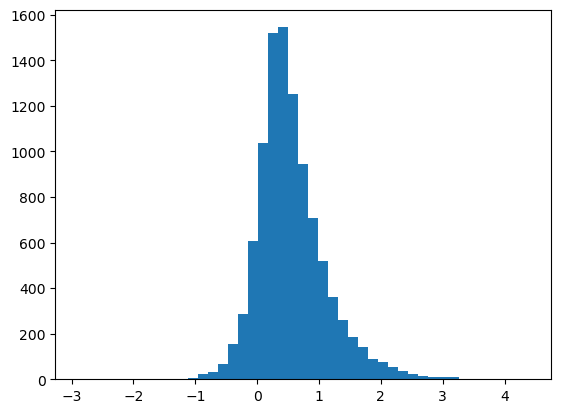

2024-01-07 23:01:58.622160
mean work = 0.5624713916598685
jarzyn = 0.6548448201818724
[80, 60, 40, 40, 40, 40, 40]


In [34]:

step_time_array = np.cumsum(np.array([x["duration"] for x in protocol_list]))/params['dt']
name_array = [x["name"] for x in protocol_list]

plt.hist(simResult["work_distribution"], bins = 45)
plt.show()
print(datetime.datetime.now())
print(f"mean work = {np.mean(simResult['work_distribution'])}")
jarzyn_term = np.mean(np.exp(-simResult["work_distribution"]))
print(f'jarzyn = {jarzyn_term}')
print([x["duration"] for x in protocol_list])

In [36]:
simResult["fidelity"]

[{'initial': [2512, 0, 0, 0],
  'final': [2511, 0, 0, 1],
  'final_percentage': ['1.000', '0.000', '0.000', '0.000']},
 {'initial': [0, 2545, 0, 0],
  'final': [2545, 0, 0, 0],
  'final_percentage': ['1.000', '0.000', '0.000', '0.000']},
 {'initial': [0, 0, 2558, 0],
  'final': [1, 0, 1, 2556],
  'final_percentage': ['0.000', '0.000', '0.000', '0.999']},
 {'initial': [0, 0, 0, 2385],
  'final': [1, 0, 1, 2383],
  'final_percentage': ['0.000', '0.000', '0.000', '0.999']}]

# saveToDatabase

In [32]:
saveToDataBase(simResult)

sim_id is: 6cf54be7132749e7fade8f80dfab1f8a2f96603b7e00c4cf2e4e48c7ee5eeee6


## Crook's analysis
By Crooks’ detailed fluctuation theorem, we have
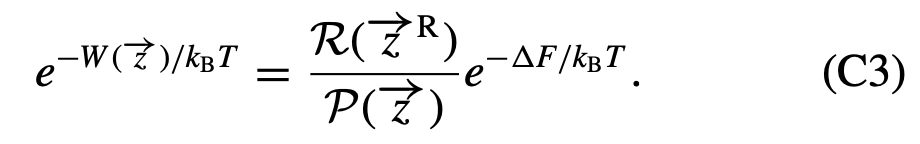

In [25]:
simResult["work_distribution"]

array([ 1.44104394, -0.0097706 ,  0.06945995, ...,  0.58566128,
        0.69014901, -0.17051567])

In [50]:
counts, bin_edges = np.histogram(simResult["work_distribution"], bins = np.linspace(-2, 2, 100),density=True)
counts, bin_edges = np.histogram(simResult["work_distribution"], bins = np.linspace(-0.09, 0.09, 10),density=True)

In [51]:
log_P_ratio = np.log(counts / counts[::-1])


Text(0, 0.5, 'log ratio')

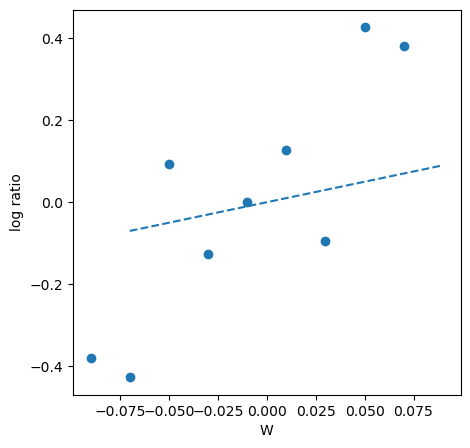

In [52]:
plt.figure(figsize=(5, 5))
plt.plot(bin_edges[1:], bin_edges[1:], "--")
plt.scatter(bin_edges[:-1], log_P_ratio)
plt.xlabel("W")
plt.ylabel("log ratio")

array([0.03030303, 0.09090909, 0.15151515, 0.21212121, 0.27272727,
       0.33333333, 0.39393939, 0.45454545, 0.51515152, 0.57575758,
       0.63636364, 0.6969697 , 0.75757576, 0.81818182, 0.87878788,
       0.93939394, 1.        , 1.06060606, 1.12121212, 1.18181818,
       1.24242424, 1.3030303 , 1.36363636, 1.42424242, 1.48484848,
       1.54545455, 1.60606061, 1.66666667, 1.72727273, 1.78787879,
       1.84848485, 1.90909091, 1.96969697, 2.03030303, 2.09090909,
       2.15151515, 2.21212121, 2.27272727, 2.33333333, 2.39393939,
       2.45454545, 2.51515152, 2.57575758, 2.63636364, 2.6969697 ,
       2.75757576])

jarzyn = 0.5441278908764094
[80, 40, 40, 40, 60, 60]


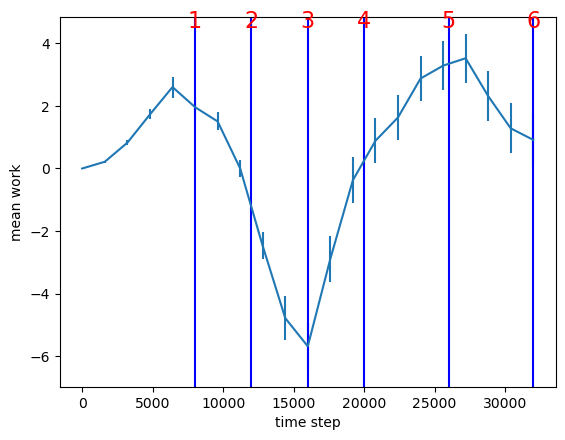

In [50]:


step_array = np.arange(simResult["work_statistic"][:,0].shape[0])
skip_step = int(len(step_array) * 0.05)
work_mean = simResult["work_statistic"][:,0]
work_std = simResult["work_statistic"][:,1]
coarse_step_array = step_array[::skip_step]
coarse_step_array = np.append(coarse_step_array, step_array[-1])
coarse_work_mean_array = work_mean[::skip_step]
coarse_work_mean_array = np.append(coarse_work_mean_array, work_mean[-1])
coarse_work_std_array = np.append(work_std[::skip_step], work_std[-1])

plt.errorbar(coarse_step_array, coarse_work_mean_array, yerr = coarse_work_std_array)

for i, t in enumerate(step_time_array):
    plt.axvline(x = t, color = 'b', label = 'axvline - full height')
    # plt.text('2017-07-02 16:30:00',0.005,'BigNews1',rotation=90,va='top')
    plt.annotate(f"{i+1}", 
            xy=(t, 4.5),  
            # xytext=(quantile_75, 2.05*1e9),
            color='red', 
            ha='center', 
            size=16)
plt.xlabel("time step")
plt.ylabel("mean work")

print(f'jarzyn = {jarzyn_term}')
print([x["duration"] for x in protocol_list])

first_half = work_mean[0: len(work_mean)//2]
second_half = work_mean[len(work_mean)//2:][::-1]
# plt.plot(step_array[0:len(step_array)//2], np.abs(first_half - second_half))

In [51]:
simResult["fidelity"]

[{'initial': [2499, 0, 0, 0],
  'final': [309, 0, 2190, 0],
  'final_percentage': ['0.124', '0.000', '0.876', '0.000']},
 {'initial': [0, 2504, 0, 0],
  'final': [322, 0, 2180, 2],
  'final_percentage': ['0.129', '0.000', '0.871', '0.001']},
 {'initial': [0, 0, 2473, 0],
  'final': [1, 2150, 0, 322],
  'final_percentage': ['0.000', '0.869', '0.000', '0.130']},
 {'initial': [0, 0, 0, 2524],
  'final': [0, 2210, 0, 314],
  'final_percentage': ['0.000', '0.876', '0.000', '0.124']}]

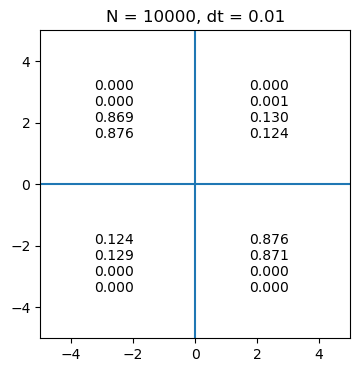

In [52]:
final_percentage_matrix = np.array([d["final_percentage"] for d in simResult["fidelity"]]).T
text_box_array = ["\n".join(row) for row in final_percentage_matrix]
plt.figure(figsize=[4, 4])
plt.title(f"N = {params['N']}, dt = {params['dt']}")
plt.xlim(-5, 5);plt.ylim(-5, 5);
plt.text(-3.25, -3.5, text_box_array[0]);plt.text(-3.25, 1.5, text_box_array[1])
plt.text(1.75, -3.5, text_box_array[2]);plt.text(1.75, 1.5, text_box_array[3])
plt.vlines(0, ymin = -5, ymax = 5);plt.hlines(0, xmin = -5, xmax = 5)

# --------------------- separatiing line --------------------- #

['1.00\n1.00\n0.00\n0.00', '0.00\n0.00\n0.00\n0.00', '0.00\n0.00\n0.00\n0.00', '0.00\n0.00\n1.00\n1.00']


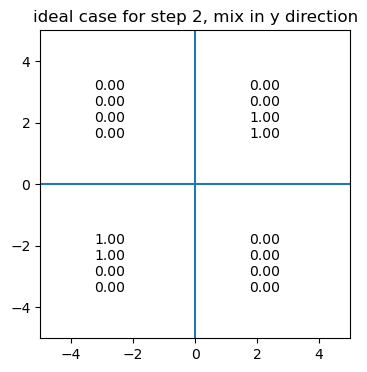

In [33]:
# ideal case

text_box_array = ['1.00\n1.00\n0.00\n0.00', '0.00\n0.00\n0.00\n0.00', '0.00\n0.00\n0.00\n0.00', '0.00\n0.00\n1.00\n1.00']

print(text_box_array)
plt.figure(figsize=[4, 4])
plt.title(f"ideal case for step 2, mix in y direction")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.text(-3.25, -3.5, text_box_array[0])
plt.text(-3.25, 1.5, text_box_array[1])
plt.text(1.75, -3.5, text_box_array[2])
plt.text(1.75, 1.5, text_box_array[3])
plt.vlines(0, ymin = -5, ymax = 5)
plt.hlines(0, xmin = -5, xmax = 5)

# # place a text box in upper left in axes coords
# ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)

In [16]:
print(cfqr.sim.output.all_state["description_text"])


            For all states, it is a N_sample x N_step x 4 x 2
            The first dimension is the sample dimension.
            The second dimension is the time step dimension.
            The order of the third dimension is phi_1, phi_2, phi_1_dc and phi_2_dc
            The order of the final dimension is (x, p) respectively.
            


[3.17067758 2.09184965] [3.24797197 1.8315607 ]


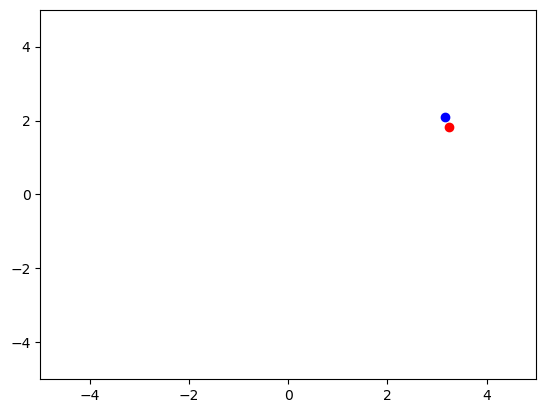

In [206]:
states = cfqr.sim.output.all_state["states"]

particle_number = 4
initial_position = states[particle_number, 0, (0, 1), 0]
final_position = states[particle_number, -1, (0, 1), 0]
print(initial_position, final_position)

plt.ylim(-5, 5)
plt.xlim(-5, 5)
plt.scatter([initial_position[0]], [initial_position[-1:]], color = "b" )
plt.scatter(final_position[0:1], final_position[-1:], color = "r" )

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

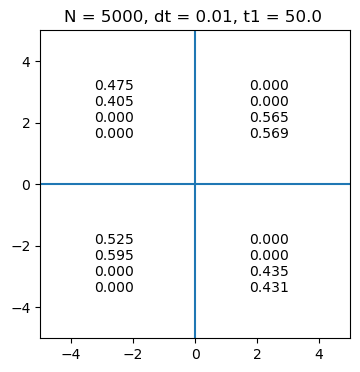

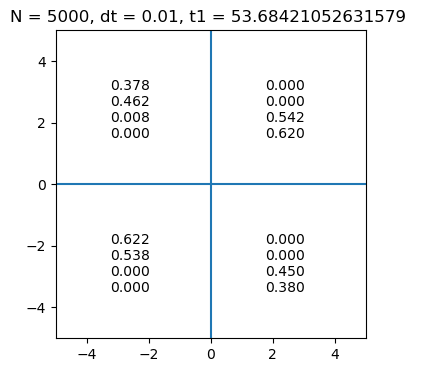

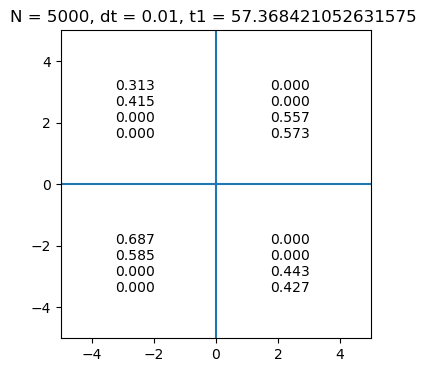

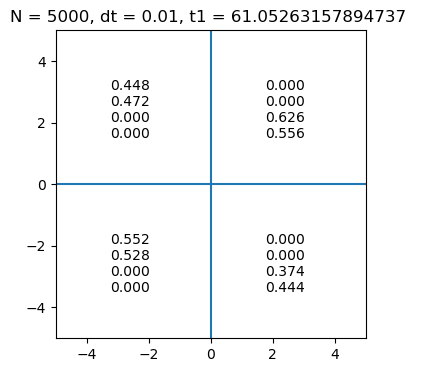

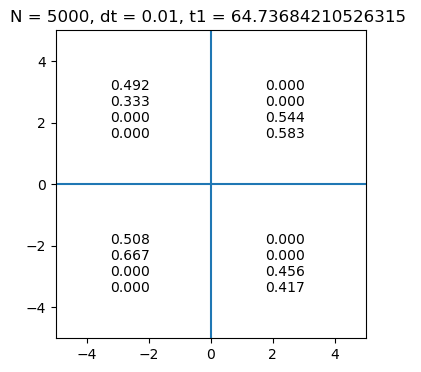

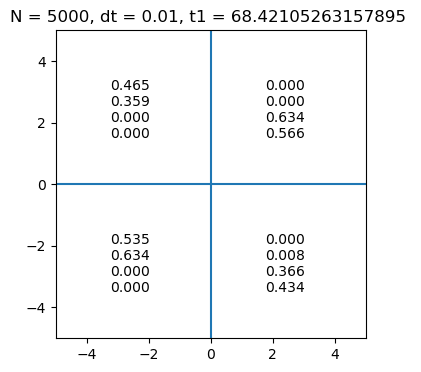

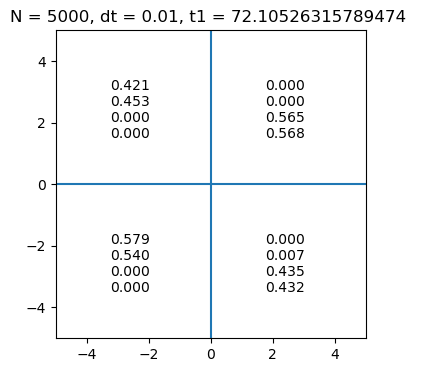

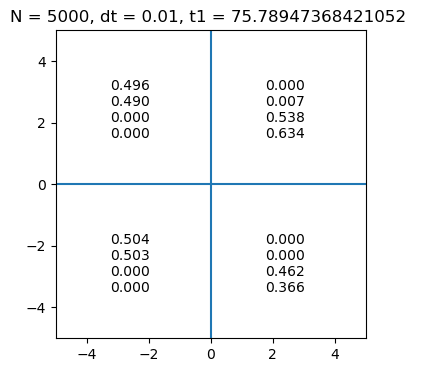

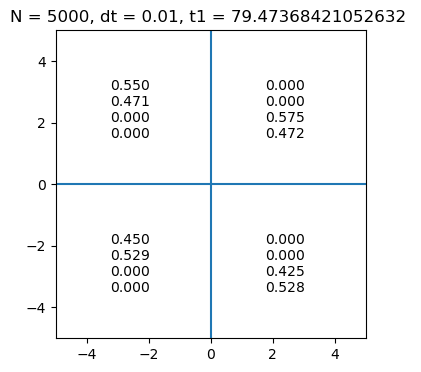

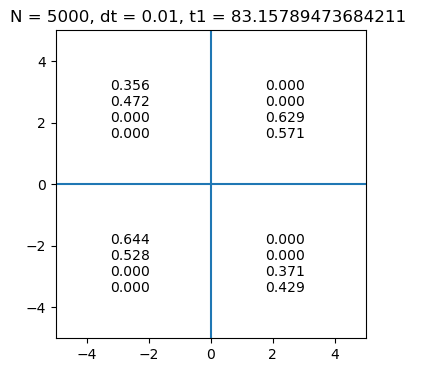

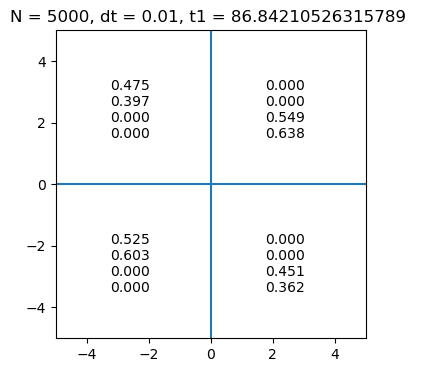

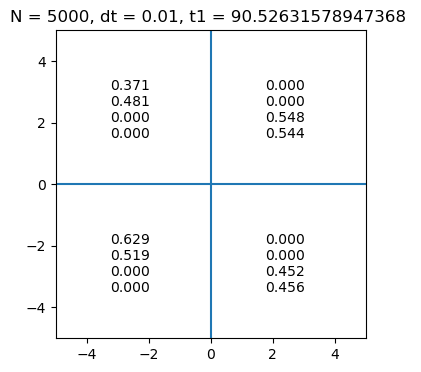

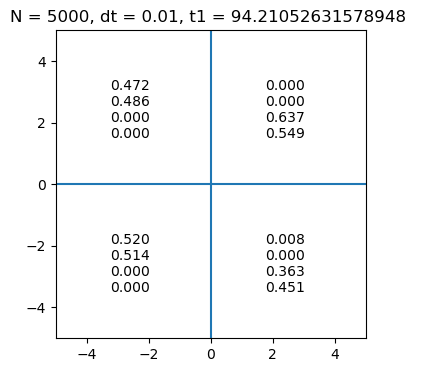

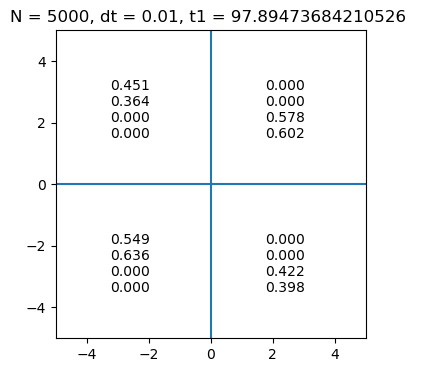

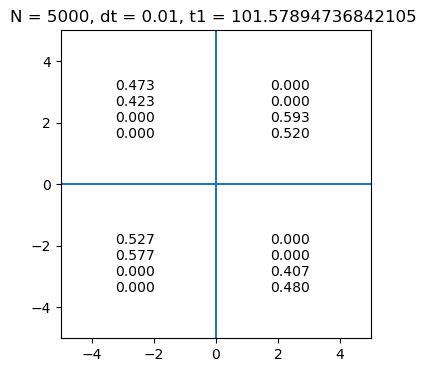

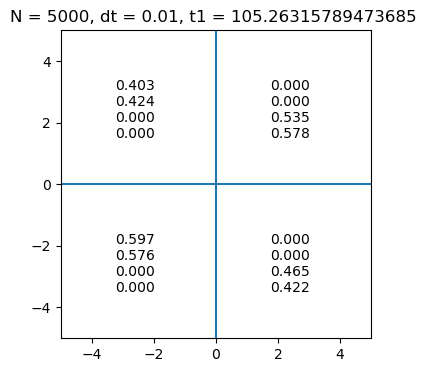

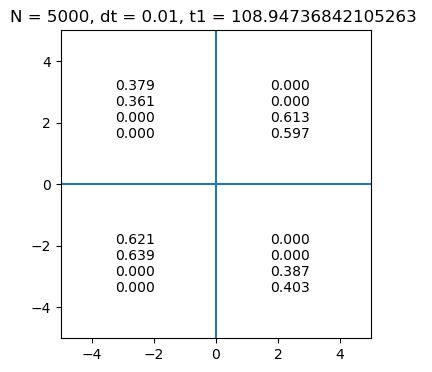

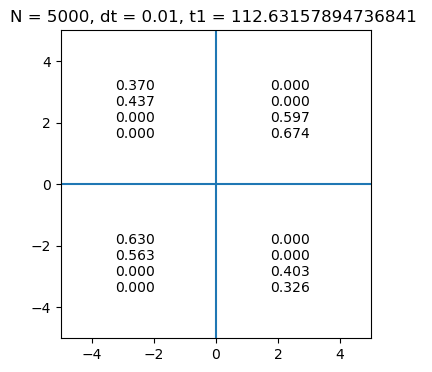

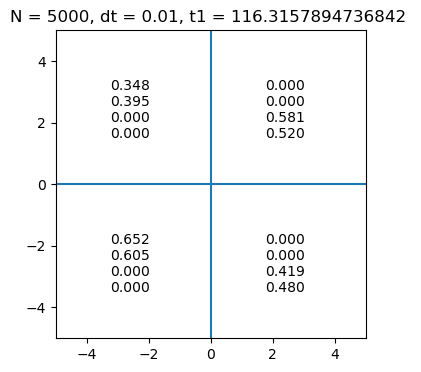

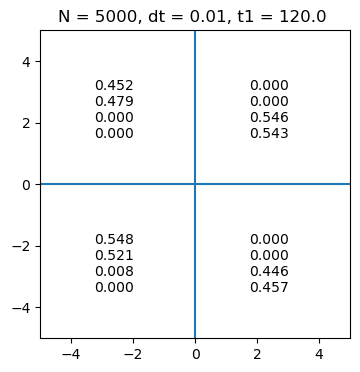

In [136]:

import json
import numpy as np
import matplotlib.pyplot as plt
with open("cfq_data/fidelity_analysis.json") as f:
    data = json.load(f)
    for item in data:
        final_percentage_matrix = np.array([d["final_percentage"] for d in item["fidelity"]]).T
        text_box_array = ["\n".join(row) for row in final_percentage_matrix]
        plt.figure(figsize=[4, 4])
        plt.title(f"N = {item['N']}, dt = {item['dt']}, t1 = {item['protocol_list'][-1]['duration']} ")
        plt.xlim(-5, 5);plt.ylim(-5, 5);
        plt.text(-3.25, -3.5, text_box_array[0]);plt.text(-3.25, 1.5, text_box_array[1])
        plt.text(1.75, -3.5, text_box_array[2]);plt.text(1.75, 1.5, text_box_array[3])
        plt.vlines(0, ymin = -5, ymax = 5);plt.hlines(0, xmin = -5, xmax = 5)
    plt.show()

In [22]:
d = {"3": 10}

In [29]:
list(d.values())[0]

10

In [173]:

import json
import numpy as np
import matplotlib.pyplot as plt

bit_array = ["00", "01", "10", "11"]
expt_number = 23

with open("cfq_data/fidelity_analysis.json") as f:
    data = json.load(f)
    data = list(filter(lambda x: x["expt_number"]==expt_number, data))
    data = list(filter(lambda x: x["tested_paramter_value"] < 0.545 and x["tested_paramter_value"] > 0.54, data))
    final_percentage_matrix_at_all_time = []
    parameter_array = [item['tested_paramter_value'] for item in data]
    mean_work =  [item['W_mean'] for item in data]
    for item in data:
        final_percentage_matrix = np.array([d["final_percentage"] for d in item["fidelity"]])
        final_percentage_matrix_at_all_time.append(final_percentage_matrix)
    final_percentage_matrix_at_all_time = np.array(final_percentage_matrix_at_all_time).astype("float")

In [174]:
mean_work

[1.9906097997898986, 1.9817910493842947]

min work =  1.9817910493842947


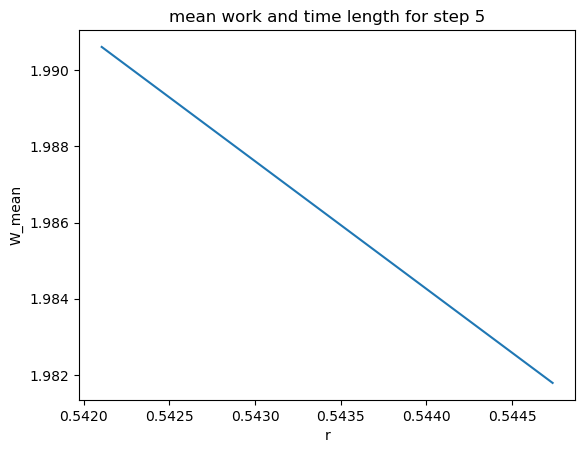

In [175]:
plt.title("mean work and time length for step 5")
plt.xlabel("r"); plt.ylabel("W_mean")
plt.plot(parameter_array, mean_work)
print("min work = ", min(mean_work))


In [176]:
sorted(zip(parameter_array, final_percentage_matrix_at_all_time), key=lambda x: x[0])

[(0.5421052631578948,
  array([[0.414, 0.586, 0.   , 0.   ],
         [0.559, 0.44 , 0.   , 0.   ],
         [0.   , 0.   , 0.421, 0.578],
         [0.   , 0.   , 0.599, 0.401]])),
 (0.5447368421052632,
  array([[0.594, 0.406, 0.   , 0.   ],
         [0.412, 0.587, 0.001, 0.   ],
         [0.   , 0.   , 0.588, 0.411],
         [0.   , 0.   , 0.419, 0.581]]))]

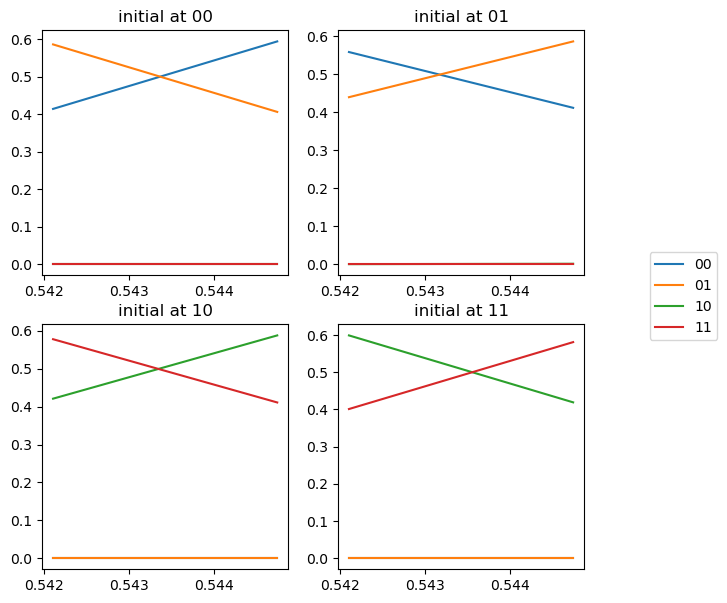

In [177]:
fig, ax = plt.subplots(2, 2, figsize=(7,7))
ax = ax.flatten()

# i_index and f_index means initial and final indices
for i_index in range(0, 4):
    ax[i_index].title.set_text(f'initial at {bit_array[i_index]}')
    for f_index in range(0, 4):
        ax[i_index].plot(parameter_array, final_percentage_matrix_at_all_time[:, i_index, f_index], label=bit_array[f_index])
    #     
    
    #     ax[index].plot(time_array, row, label = bit_array[index])
    #     ax[index].title.set_text(f'initial at {bit_array[index]}')
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc = 5, bbox_to_anchor=(1.1, 0.5))



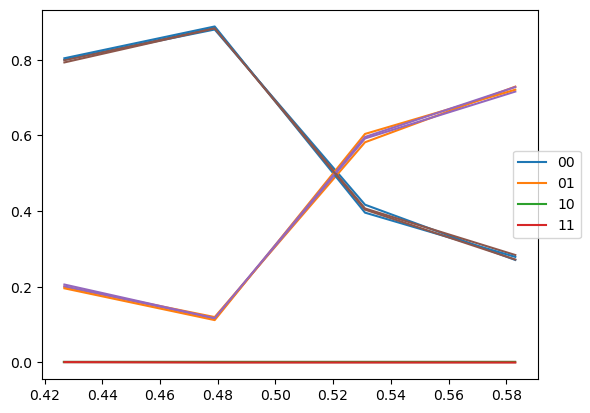

In [144]:




for i_index in range(0, 4):
    ax[i_index].title.set_text(f'initial at {bit_array[i_index]}')
    for f_index in range(0, 4):
        plt.plot(parameter_array, final_percentage_matrix_at_all_time[:, i_index, f_index], label=bit_array[f_index])
plt.legend(handles, labels, loc = 5, bbox_to_anchor=(1.1, 0.5))



In [76]:
final_percentage_matrix_at_all_time

array([[[0.565, 0.435, 0.   , 0.   ],
        [0.535, 0.465, 0.   , 0.   ],
        [0.   , 0.   , 0.524, 0.476],
        [0.   , 0.   , 0.47 , 0.53 ]],

       [[0.786, 0.214, 0.   , 0.   ],
        [0.195, 0.805, 0.   , 0.   ],
        [0.   , 0.   , 0.772, 0.228],
        [0.   , 0.   , 0.2  , 0.8  ]],

       [[0.196, 0.804, 0.   , 0.   ],
        [0.774, 0.226, 0.   , 0.   ],
        [0.   , 0.   , 0.236, 0.764],
        [0.   , 0.   , 0.773, 0.227]],

       [[0.6  , 0.4  , 0.   , 0.   ],
        [0.435, 0.565, 0.   , 0.   ],
        [0.   , 0.   , 0.569, 0.431],
        [0.   , 0.   , 0.449, 0.551]],

       [[0.575, 0.425, 0.   , 0.   ],
        [0.321, 0.679, 0.   , 0.   ],
        [0.   , 0.   , 0.637, 0.363],
        [0.   , 0.   , 0.481, 0.519]],

       [[0.626, 0.374, 0.   , 0.   ],
        [0.347, 0.653, 0.   , 0.   ],
        [0.   , 0.   , 0.664, 0.336],
        [0.   , 0.   , 0.333, 0.667]],

       [[0.234, 0.766, 0.   , 0.   ],
        [0.705, 0.295, 0.   , 0.   ],


In [66]:
bit_array = ["00", "01", "10", "11"]

In [67]:
# dimension: [time, init_bit, final_bit]
final_percentage_matrix_at_all_time[0:3, 0, 0]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [57]:
final_percentage_matrix_at_all_time

array([[['0.565', '0.435', '0.000', '0.000'],
        ['0.535', '0.465', '0.000', '0.000'],
        ['0.000', '0.000', '0.524', '0.476'],
        ['0.000', '0.000', '0.470', '0.530']],

       [['0.786', '0.214', '0.000', '0.000'],
        ['0.195', '0.805', '0.000', '0.000'],
        ['0.000', '0.000', '0.772', '0.228'],
        ['0.000', '0.000', '0.200', '0.800']],

       [['0.196', '0.804', '0.000', '0.000'],
        ['0.774', '0.226', '0.000', '0.000'],
        ['0.000', '0.000', '0.236', '0.764'],
        ['0.000', '0.000', '0.773', '0.227']],

       [['0.600', '0.400', '0.000', '0.000'],
        ['0.435', '0.565', '0.000', '0.000'],
        ['0.000', '0.000', '0.569', '0.431'],
        ['0.000', '0.000', '0.449', '0.551']],

       [['0.575', '0.425', '0.000', '0.000'],
        ['0.321', '0.679', '0.000', '0.000'],
        ['0.000', '0.000', '0.637', '0.363'],
        ['0.000', '0.000', '0.481', '0.519']],

       [['0.626', '0.374', '0.000', '0.000'],
        ['0.347', '0.653

[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


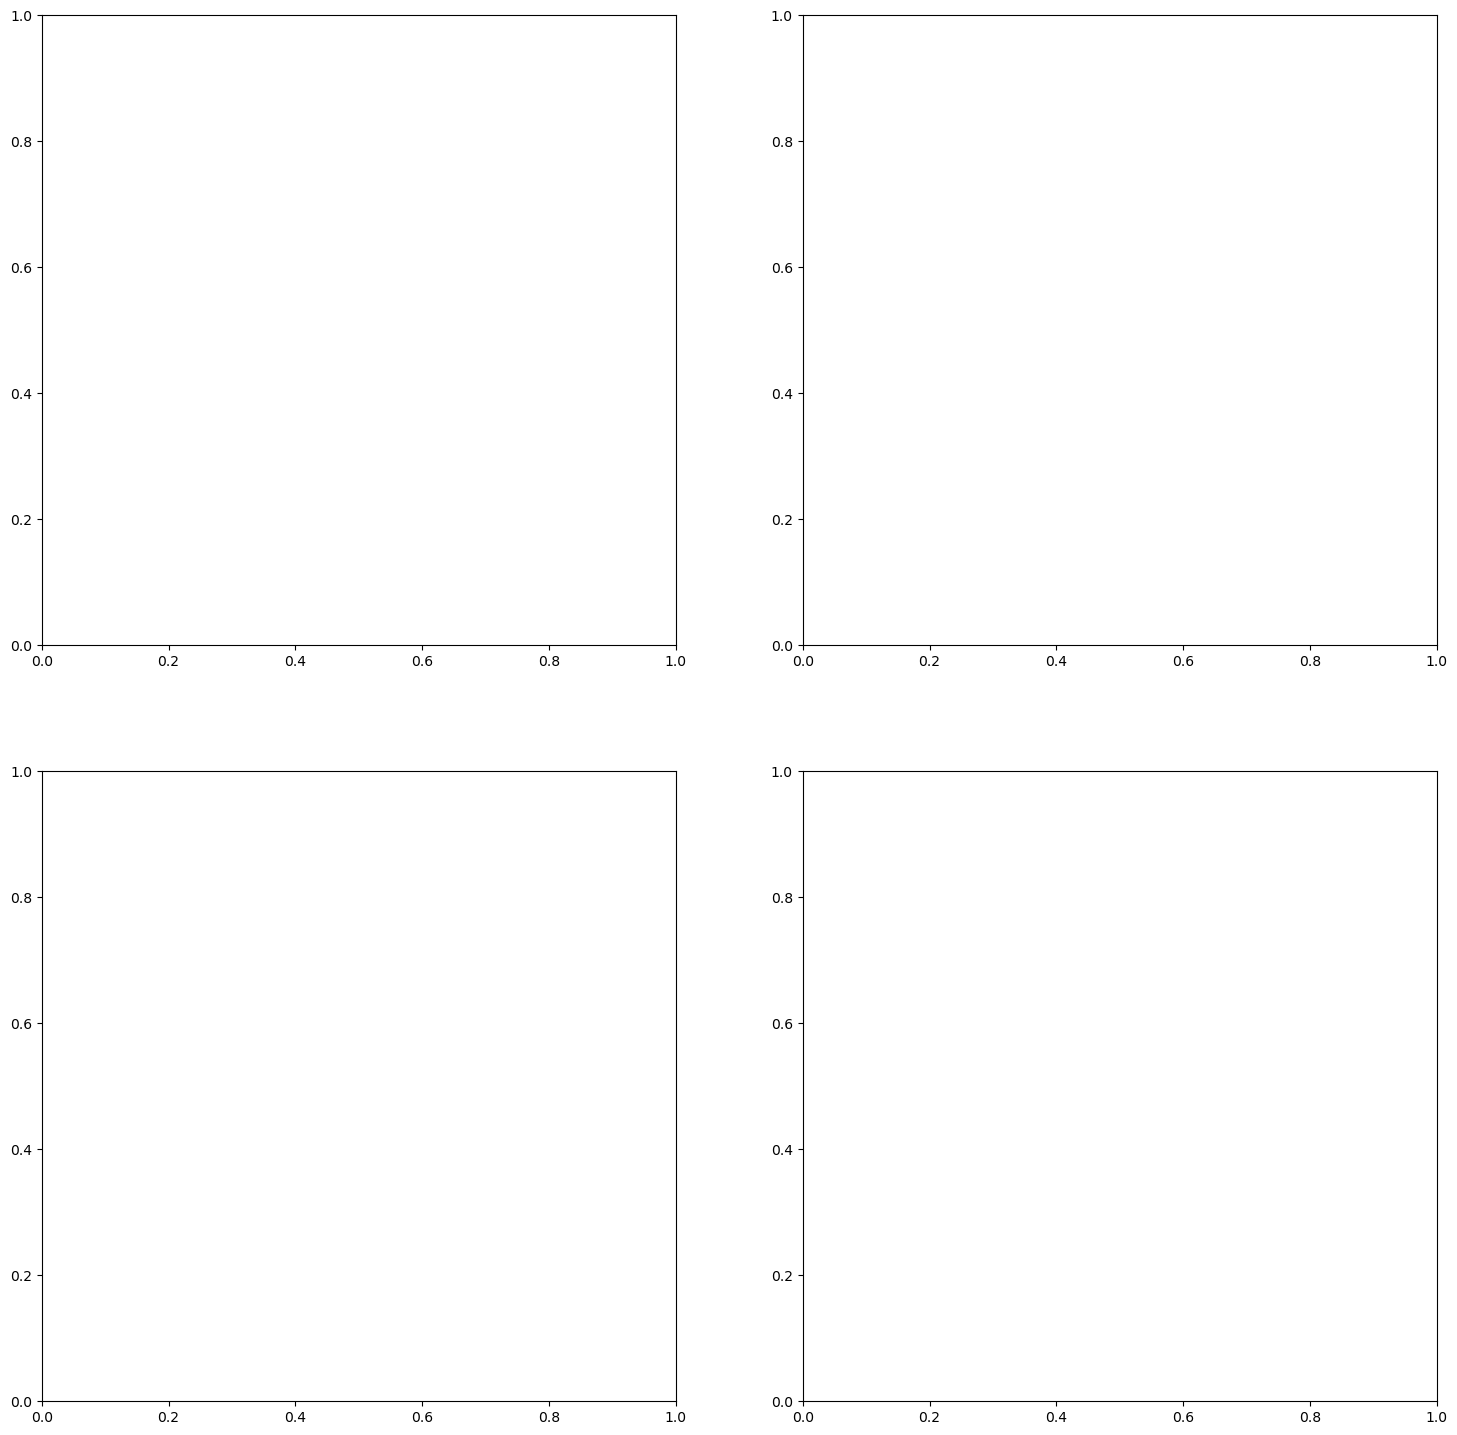

In [55]:
fig, ax = plt.subplots(2, 2, figsize=(18, 18))
ax = ax.flatten()

# ax[1].legend()
for index, row in enumerate(final_percentage_matrix_at_all_time[:, :, i].T.astype("float")):
    print(row)
    # for i in range(0, 4):
    #     ax[index].plot(time_array, row, label = bit_array[index])
    #     ax[index].title.set_text(f'initial at {bit_array[index]}')
    #     ax[index].legend(bbox_to_anchor=(1, 1))

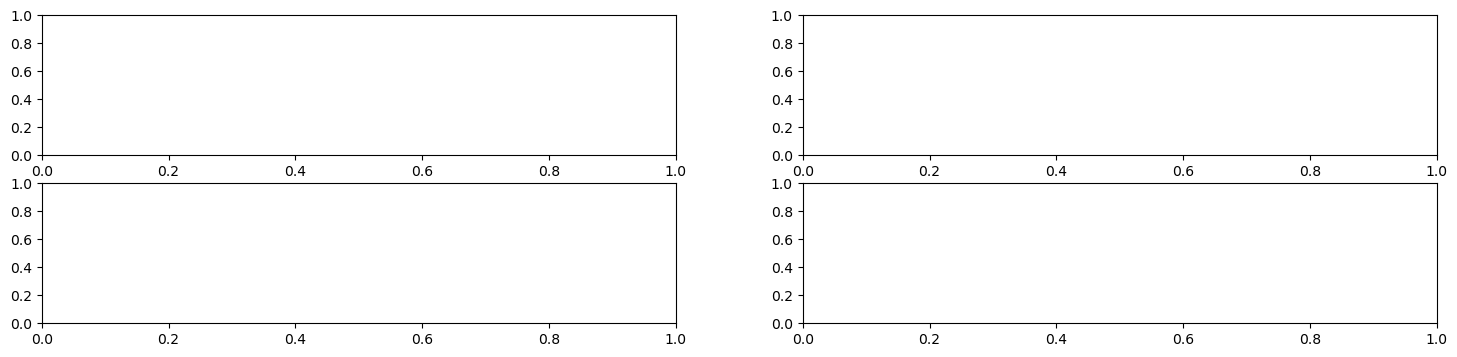

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(18,4))



In [45]:
ax.flatten()

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

In [36]:
def extra_constraint(state):
    # to check if the particle is at the position of bit 11
    tf_array_11 = np.logical_and(state[:,0, 0] > 0, state[:,1, 0] > 0)

    # to check if the particle is at the position of bit 00
    tf_array_00 = np.logical_and(state[:,0, 0] < 0, state[:,1, 0] < 0)

    tf_array_00_or_11 = np.logical_or(tf_array_00, tf_array_11).astype(int)
    return tf_array_00_or_11

def self_defined_initial_state(cfqr, Nsample, t=None, resolution=500, beta=1, manual_domain=None, axes=None, slice_vals=None, verbose=True, extra_constraint = None):
        if cfqr.potential.N_dim >= 4 and (axes is None or len(axes) > 4):
            if resolution > 100:
                if cfqr.potential.N_dim >= 4:
                    resolution = 50
                print('new resolution is {}'.format(resolution))

        NT = Nsample
        state = np.zeros((max(100, int(2*NT)), cfqr.potential.N_dim, 2))

        def get_prob(cfqr, state):
            if cfqr.has_velocity is False:
                state = state[:, :, 0]
            E_curr = cfqr.get_energy(state, t)
            Delta_U = E_curr-U0
            
            if extra_constraint:
                return np.exp(-beta * Delta_U) * extra_constraint(state)
            else:
                return np.exp(-beta * Delta_U)

        if t is None:
            t = cfqr.protocol.t_i

        U, X = cfqr.lattice(t, resolution, axes=axes, slice_values=slice_vals, manual_domain=manual_domain)
        mins = []; maxes = []
        for item in X:
            mins.append(np.min(item))
            maxes.append(np.max(item))

        U0 = np.min(U); i = 0

        if axes is None:
            axes = [_ for _ in range(1, cfqr.potential.N_dim + 1)]
        axes = np.array(axes) - 1

        while i < Nsample:
            test_coords = np.zeros((NT, cfqr.potential.N_dim, 2))
            if slice_vals is not None:
                test_state[:, :, 0] = slice_vals

            # this is the state generated to test
            test_coords[:, axes, 0] = np.random.uniform(mins, maxes, (NT, len(axes)))

            p = get_prob(cfqr, test_coords)

            decide = np.random.uniform(0, 1, NT)
            n_sucesses = np.sum(p > decide)
            if i == 0:
                ratio = max(n_sucesses/NT, .05)

            state[i:i+n_sucesses, :, :] = test_coords[p > decide, :, :]
            i = i + n_sucesses
            if verbose:
                print(f"\r found {i} samples out of {Nsample}", end="")

            NT = max(int((Nsample-i)/ratio), 100)

        print("\nfrom system: finish the while loop in sampling.")
        state = state[0:Nsample, :, :]
        # print("the state is", state)

        if cfqr.has_velocity:
            state[:, :, 1] = np.random.normal(0, np.sqrt(1/(cfqr.mass*beta)), (Nsample, cfqr.potential.N_dim))
        else:
            return state[:, :, 0]

        return state

In [37]:
i_state = self_defined_initial_state(cfqr.eq_system, N, extra_constraint=extra_constraint)

new resolution is 50
 found 10000 samples out of 10000
from system: finish the while loop in sampling.


In [27]:
E_curr = cfqr.eq_system.get_energy(initial_state, 0)
Delta_U = E_curr
np.exp(-Delta_U)
# extra_constraint

array([0.01598703, 5.98816538, 0.42302912, ..., 0.96836715, 1.24562888,
       3.98776273])

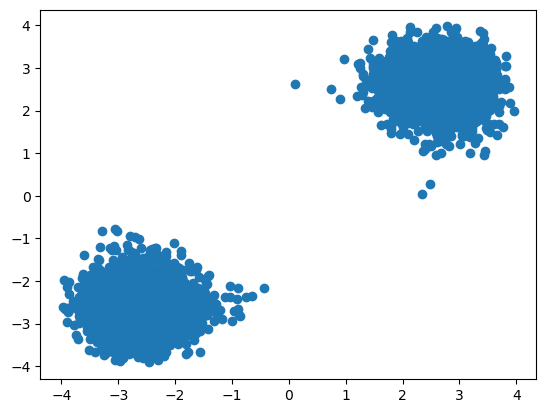

In [35]:
plt.scatter(i_state[:, 0, 0], i_state[:, 1, 0])

array([-2.61554703, -2.74671882,  2.44224483, ...,  3.27286327,
       -2.52613998,  2.23315879])

array([ 1.86693327, -1.93684954, -2.8022977 , ...,  2.59059199,
        2.87227472,  2.34936203])

In [57]:
# to check if the particle is at the position of bit 11
tf_array_11 = np.logical_and(initial_state[:,0, 0] > 0, initial_state[:,1, 0] > 0)

# to check if the particle is at the position of bit 00
tf_array_00 = np.logical_and(initial_state[:,0, 0] < 0, initial_state[:,1, 0] < 0)

tf_array_00_or_11 = np.logical_or(tf_array_00, tf_array_11)

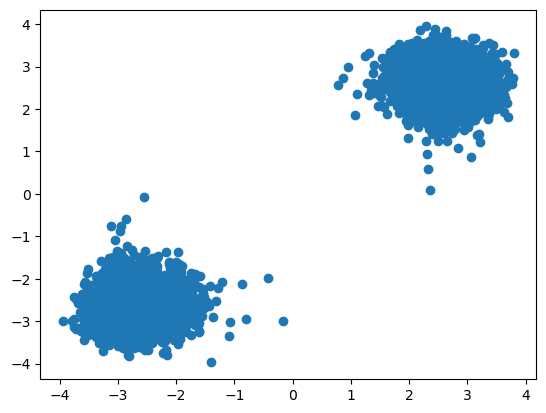

In [58]:
plt.scatter(initial_state[:, 0, 0][tf_array_00_or_11], initial_state[:, 1, 0][tf_array_00_or_11])

In [43]:
initial_state[:10,(0, 1), 0] > 0

array([[False,  True],
       [False, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [False, False],
       [ True,  True],
       [False,  True],
       [False,  True],
       [False,  True]])

In [50]:
np.sum(tf_array_00  tf_array_11)

0